In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sympy as sp
from IPython.display import display, Math, Latex
from scipy.integrate import solve_ivp
import ipywidgets as widgets
from ipywidgets import interact, IntSlider, FloatSlider

%matplotlib widget

In [22]:
x0, k0 = 1, 0
x_sym, k_sym = sp.symbols('x k')

names = ['Airy', 'Weber', 'Himmelblau']
def get_H(name, params=None):
    if name == 'Airy':
        H = lambda x, k: (x-1) + k**2
    if name == 'Weber':
        H = lambda x, k: x**2 + k**2 - 1
    if name == 'Himmelblau':
        H1 = lambda x, k: (x**2 + k - 11)
        H2 = lambda x, k: (x + k**2 - 7)
        offset = H1(x0,k0)**2 + H2(x0,k0)**2
        H = lambda x, k: -1/50*(H1(x,k)**2 + H2(x,k)**2 - offset)
    # if name == 'Multigaussian':
    #     if params is None:
    #         N, R, l = 4, 1, 0.7
    #     else:
    #         N, R, l = params
    #     zns = [sp.Matrix([R*sp.cos(n*2*sp.pi/N), R*sp.sin(n*2*sp.pi/N)]) for n in range(1,N+1)]
    #     H = lambda x, k: -sp.Rational(1, 2) + sum(sp.exp(-((x - zn[0])**2 + (k - zn[1])**2)/l**2) for zn in zns)
    return H

t_spans = {'Airy': [-np.sqrt(6)/2, np.sqrt(6)/2], 'Weber': [0, np.pi], 'Himmelblau': [0, 18.52]}

def dzn(H):
    x, k = sp.symbols('x k')
    d0 = H(x, k)
    d1 = sp.Matrix([sp.diff(d0, v) for v in (x, k)])
    d2 = sp.hessian(d0, (x, k))
    return d0, d1, d2

J_sp = sp.Matrix([[0, 1], [-1, 0]])

def zdot(dH):
    zdot = J_sp @ dH
    return zdot

def zddot(ddH, zdot):
    zddot = J_sp @ ddH @ zdot
    return zddot

# solve the system of ODEs with zdot as the right-hand side
def trace_ray(zdot, z0, t_span=[0, 10], nt=100):
    t_eval = np.linspace(t_span[0], t_span[1], nt)
    sol = solve_ivp(lambda t, z: zdot(z[0], z[1]).squeeze(), t_span, z0, t_eval=t_eval, method='RK45', rtol=1e-6, atol=1e-6)
    return sol.t, sol.y

In [24]:
def choose_H(name):
    global H, H_sp, dH_sp, ddH_sp, dH, zdot_sp, zdot_np, zddot_sp, zddot_np, ts, zs
    H = get_H(name)
    H_sp, dH_sp, ddH_sp = dzn(H)
    dH = sp.lambdify((x_sym, k_sym), dH_sp, 'numpy')
    zdot_sp = zdot(dH_sp)
    zdot_np = sp.lambdify((x_sym, k_sym), zdot_sp, 'numpy')
    zddot_sp = zddot(ddH_sp, zdot_sp)
    zddot_np = sp.lambdify((x_sym, k_sym), zddot_sp, 'numpy')

    ts, zs = trace_ray(zdot_np, np.array([x0, k0]), t_span=t_spans[name], nt=1000)

    display(Latex(r'$H(x,k) =' + sp.latex(H_sp) + '$'))
    display(Latex(r'$\partial_z H(x,k) =' + sp.latex(dH_sp) + '$'))
    display(Latex(r'$\partial_z^2 H(x,k) =' + sp.latex(ddH_sp) + '$'))

name = 'Himmelblau'
choose_H(name)

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

interactive(children=(Dropdown(description='name', index=2, options=('Airy', 'Weber', 'Himmelblau'), value='Hi…

interactive(children=(IntSlider(value=0, description='Time step', max=999), Output()), _dom_classes=('widget-i…

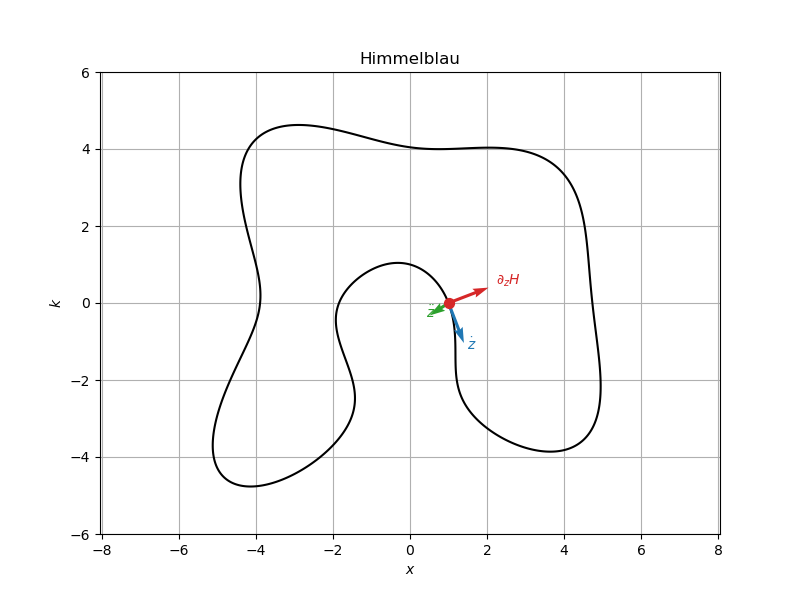

In [27]:
def set_it(_it):
    global it, zt, xt, kt, dht, zdott, zddott
    it = _it
    zt = zs[:, it]
    xt, kt = zt[0], zt[1]
    dht = dH(xt, kt)
    zdott = zdot_np(xt, kt)
    zddott = zddot_np(xt, kt)

def plot_it(it, ax):
    global zt_point, dht_quiver, zdott_quiver, zddott_quiver, dht_label, zdott_label, zddott_label, label_offset
    set_it(it)

    dht_quiver = ax.quiver(xt, kt, dht[0, 0], dht[1, 0], angles='xy', scale_units='xy', scale=1, color='tab:red', width=0.005, zorder=3)
    zdott_quiver = ax.quiver(xt, kt, zdott[0, 0], zdott[1, 0], angles='xy', scale_units='xy', scale=1, color='tab:blue', width=0.005, zorder=3)
    zddott_quiver = ax.quiver(xt, kt, zddott[0, 0], zddott[1, 0], angles='xy', scale_units='xy', scale=1, color='tab:green', width=0.005, zorder=3)
    zt_point = ax.scatter(xt, kt, color='tab:red', label=r'$z_0$', s=50, zorder=3)

    label_offset = 0.2
    dht_label = ax.annotate(r'$\partial_{z} H$', xy=(xt + dht[0, 0] + label_offset * dht[0, 0]/np.linalg.norm(dht), kt + dht[1, 0] + label_offset * dht[1, 0]/np.linalg.norm(dht)), 
            xytext=(5, 5), textcoords='data', color='tab:red')
    zdott_label = ax.annotate(r'$\dot{z}$', xy=(xt + zdott[0, 0] + label_offset * zdott[0, 0]/np.linalg.norm(dht), kt + zdott[1, 0] + label_offset * zdott[1, 0]/np.linalg.norm(dht)), 
                xytext=(5, 5), textcoords='data', color='tab:blue')
    zddott_label = ax.annotate(r'$\ddot{z}$', xy=(xt + zddott[0, 0] + label_offset * zddott[0, 0]/np.linalg.norm(dht), kt + zddott[1, 0] + label_offset * zddott[1, 0]/np.linalg.norm(dht)), 
                xytext=(5, 5), textcoords='data', color='tab:green')

def update_it(it):
    set_it(it)
    # Update scatter point
    zt_point.set_offsets([[xt, kt]])
    # Update quivers
    dht_quiver.set_UVC(dht[0, 0], dht[1, 0])
    dht_quiver.set_offsets([[xt, kt]])
    zdott_quiver.set_UVC(zdott[0, 0], zdott[1, 0])
    zdott_quiver.set_offsets([[xt, kt]])
    zddott_quiver.set_UVC(zddott[0, 0], zddott[1, 0])
    zddott_quiver.set_offsets([[xt, kt]])
    
    dht_label.set_position((xt + dht[0, 0] + label_offset * dht[0, 0]/np.linalg.norm(dht), kt + dht[1, 0] + label_offset * dht[1, 0]/np.linalg.norm(dht)))
    zdott_label.set_position((xt + zdott[0, 0] + label_offset * zdott[0, 0]/np.linalg.norm(dht), kt + zdott[1, 0] + label_offset * zdott[1, 0]/np.linalg.norm(dht)))
    zddott_label.set_position((xt + zddott[0, 0] + label_offset * zddott[0, 0]/np.linalg.norm(dht), kt + zddott[1, 0] + label_offset * zddott[1, 0]/np.linalg.norm(dht)))

def plot_H(name):
    choose_H(name)

    xs = np.linspace(-6, 6, 400)
    ks = np.linspace(-6, 6, 400)
    X, K = np.meshgrid(xs, ks)
    h = H(X, K)

    fig = plt.figure(num=1)
    fig.clf()
    fig.set_size_inches(8, 6)
    ax = fig.add_subplot(1, 1, 1)

    ax.grid()
    ax.axis("equal")
    ax.contour(X, K, h, levels=0, colors='k')

    plot_it(0, ax)
    update_it(0)
    # plt.quiver(X[::20, ::20], K[::20, ::20], grad_x[::20, ::20], grad_k[::20, ::20], color='b', alpha=0.7)
    plt.xlabel(r"$x$")
    plt.ylabel(r"$k$")
    plt.title(f"{name}")

widgets.interact(plot_H, name=widgets.Dropdown(options=['Airy', 'Weber', 'Himmelblau'], value=name))
slider = IntSlider(value=0, min=0, max=len(zs[0])-1, step=1, description='Time step')
interact(update_it, it=slider)

plt.show()